## Imports

In [15]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, top_k_accuracy_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from hyperopt.pyll.base import scope
from scipy.stats import wilcoxon
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)

### Loading the data splits

In [16]:
# Step 0: Load the datasets
train_data = pd.read_csv('Knowledge_base_train.csv')
test_data = pd.read_csv('Knowledge_base_test.csv')

# Separate features and target
X_train = train_data.drop(columns=["class"])
y_train = train_data["class"]
X_test = test_data.drop(columns=["class"])
y_test = test_data["class"]

### Finding the best baseline model

In [17]:
# Step 1: Build and train baseline models with default hyperparameters
def train_baseline_models(X_train, y_train, X_test, y_test):
  models = {"RandomForest": RandomForestClassifier(),
            "DecisionTree": DecisionTreeClassifier(),
            "LogisticRegression": LogisticRegression(max_iter=1000),
            "SVM": SVC(probability=True),
            "KNN": KNeighborsClassifier(),
            "GradientBoosting": GradientBoostingClassifier()
  }
  baseline_results = {}
  for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    preds_probs = model.predict_proba(X_test)
    score = f1_score(y_test, predictions, average='micro')
    acc_3 = top_k_accuracy_score(y_test, preds_probs, k=3)
    loss = log_loss(y_test, preds_probs)
    baseline_results[model_name] = (loss, -score, -acc_3)
    print(f"{model_name} Micro F1-Score: {score:.4f} - Acc@3: {acc_3:.4f} - Log Loss: {loss:.4f}")

  # Select the best model
  best_model_name = min(baseline_results, key=baseline_results.get)
  baseline_results_summary = {'f1': -1*baseline_results[best_model_name][1],
                              'acc3': -1*baseline_results[best_model_name][2],
                              'log_loss': baseline_results[best_model_name][0]}
  print(f"Best Baseline Model: {best_model_name} with \nMicro F1-Score: {-1*baseline_results[best_model_name][1]:.4f}")
  print(f"Accuracy@3: {-1*baseline_results[best_model_name][2]:.4f}")
  print(f"Log Loss: {baseline_results[best_model_name][0]:.4f}")
  return best_model_name, models[best_model_name], baseline_results_summary

best_baseline_name, best_baseline_model, baseline_results = train_baseline_models(X_train, y_train, X_test, y_test)

RandomForest Micro F1-Score: 0.6200 - Acc@3: 0.9100 - Log Loss: 1.3780
DecisionTree Micro F1-Score: 0.6000 - Acc@3: 0.7800 - Log Loss: 14.4175


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Micro F1-Score: 0.5400 - Acc@3: 0.8400 - Log Loss: 1.3746
SVM Micro F1-Score: 0.4400 - Acc@3: 0.8300 - Log Loss: 1.4378
KNN Micro F1-Score: 0.4400 - Acc@3: 0.8000 - Log Loss: 8.9920
GradientBoosting Micro F1-Score: 0.5900 - Acc@3: 0.9200 - Log Loss: 1.2613
Best Baseline Model: GradientBoosting with 
Micro F1-Score: 0.5900
Accuracy@3: 0.9200
Log Loss: 1.2613


### Define the search space to be used with hyper-opt

In [24]:
from sklearn.model_selection import StratifiedKFold

def objective(params):
    model_name = params["model_name"]
    del params["model_name"]

    if model_name == "RandomForest":
      model = RandomForestClassifier(**params)
    elif model_name == "DecisionTree":
      model = DecisionTreeClassifier(**params)
    elif model_name == "LogisticRegression":
      model = LogisticRegression(**params, max_iter=1000)
    elif model_name == "SVM":
      model = SVC(probability=True, **params)
    elif model_name == "KNN":
      model = KNeighborsClassifier(**params)
    elif model_name == "GradientBoostingClassifier":
      model = GradientBoostingClassifier(**params)
    else:
      raise ValueError(f"Unknown model name: {model_name}")

    pipeline = Pipeline([("scaler", StandardScaler()), ("classifier", model)])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []
    acc3_scores = []
    log_losses = []

    for train_index, val_index in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        pipeline.fit(X_train_fold, y_train_fold)
        predictions = pipeline.predict(X_val_fold)
        preds_probs = pipeline.predict_proba(X_val_fold)

        f1_scores.append(f1_score(y_val_fold, predictions, average='micro'))
        acc3_scores.append(top_k_accuracy_score(y_val_fold, preds_probs, k=3))
        log_losses.append(log_loss(y_val_fold, preds_probs))

    mean_f1 = np.mean(f1_scores)
    mean_acc3 = np.mean(acc3_scores)
    mean_loss = np.mean(log_losses)

    return {"loss": mean_loss,
            "status": STATUS_OK,
            "log_loss": mean_loss,
            "f1-metric": mean_f1,
            "acc3-metric": mean_acc3}

In [25]:
# Defining the hyperparameter search space
search = [
    {
        "model_name": "RandomForest",
        "n_estimators": scope.int(hp.quniform("rf-n_estimators", 50, 300, 10)),
        "max_depth": scope.int(hp.quniform("rf-max_depth", 3, 20, 1)),
        "min_samples_split": scope.int(hp.quniform("rf-min_samples_split", 2, 10, 1))
    },
    {
        "model_name": "DecisionTree",
        "max_depth": scope.int(hp.quniform("dt-max_depth", 3, 20, 1)),
        "min_samples_split": scope.int(hp.quniform("dt-min_samples_split", 2, 10, 1))
    },
    {
        "model_name": "LogisticRegression",
        "C": hp.loguniform("lr-C", -4, 2),
        "solver": hp.choice("lr-solver", ["lbfgs", "liblinear"])
    },
    {
        "model_name": "SVM",
        "C": hp.loguniform("svm-C", -4, 2),
        "kernel": hp.choice("svm-kernel", ["linear", "rbf"])
    },
    {
        "model_name": "KNN",
        "n_neighbors": scope.int(hp.quniform("knn-n_neighbors", 3, 20, 1))
    },
    {
        "model_name": "GradientBoostingClassifier",
        "learning_rate": hp.loguniform("gb-learning_rate", -6, 1),
        "n_estimators": scope.int(hp.quniform("gb-n_estimators", 50, 300, 10)),
        "max_depth": scope.int(hp.quniform("gb-max_depth", 3, 20, 1)),
        "min_samples_split": scope.int(hp.quniform("gb-min_samples_split", 2, 10, 1))
    },
]
search_space = hp.choice("classifier_type", search)

In [26]:
trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=search_space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print("Best Hyperparameters:", best_hyperparams)

100%|██████████| 100/100 [12:01<00:00,  7.21s/trial, best loss: 1.048142870538166]
Best Hyperparameters: {'classifier_type': 0, 'rf-max_depth': 10.0, 'rf-min_samples_split': 4.0, 'rf-n_estimators': 240.0}


### Optimized Model Performance using Hyper-Opt

In [27]:
# Training and evaluating the best model with optimized hyperparameters
def get_best_model_from_hyperparams(best_hyperparams):
  print('---> best:', best_hyperparams)
  model_name = search[best_hyperparams["classifier_type"]]["model_name"]
  params = {k.split('-')[-1]: v for k, v in best_hyperparams.items() if k != "classifier_type" and k != "model_name"}
  if 'solver' in params.keys():
    params['solver'] = 'lbfgs' if params['solver'] == 0 else 'liblinear'
  elif 'kernel' in params.keys():
    params['kernel'] = 'linear' if params['kernel'] == 0 else 'rbf'

  for param_name in ["max_depth", "n_estimators", "min_samples_split", "n_neighbors"]:
    if param_name in params:
      params[param_name] = int(params[param_name])

  if model_name == "RandomForest":
    model = RandomForestClassifier(**params)
  elif model_name == "DecisionTree":
    model = DecisionTreeClassifier(**params)
  elif model_name == "LogisticRegression":
    model = LogisticRegression(**params, max_iter=1000)
  elif model_name == "SVM":
    model = SVC(**params, probability=True)
  elif model_name == "KNN":
    model = KNeighborsClassifier(**params)
  elif model_name == "GradientBoostingClassifier":
    model = GradientBoostingClassifier(**params)
  else:
    raise ValueError(f"Unknown model name: {model_name}")

  return Pipeline([("scaler", StandardScaler()), ("classifier", model)])

optimized_model_pipeline = get_best_model_from_hyperparams(best_hyperparams)
optimized_model_pipeline.fit(X_train, y_train)
optimized_predictions = optimized_model_pipeline.predict(X_test)
optimized_preds_probs = optimized_model_pipeline.predict_proba(X_test)
optimized_f1 = f1_score(y_test, optimized_predictions, average='micro')
optimized_loss = log_loss(y_test, optimized_preds_probs)
optimized_acc_3 = top_k_accuracy_score(y_test, optimized_preds_probs, k=3)

print(f"Optimized Model Acc@3: {optimized_acc_3:.4f} -  Micro F1-Score performance: {optimized_f1:.4f} - Loss Value {optimized_loss:.4f}")

---> best: {'classifier_type': 0, 'rf-max_depth': 10.0, 'rf-min_samples_split': 4.0, 'rf-n_estimators': 240.0}
Optimized Model Acc@3: 0.9400 -  Micro F1-Score performance: 0.6500 - Loss Value 1.0103


### Wilcoxon Signed Rank Test

In [28]:
# Calculate losses for each instance in the test set for both models
baseline_probs = best_baseline_model.predict_proba(X_test)
baseline_losses = [-log_loss([true_y], [prob], labels=best_baseline_model.classes_) for true_y, prob in zip(y_test, baseline_probs)]
optimized_probs = optimized_model_pipeline.predict_proba(X_test)
optimized_losses = [-log_loss([true_y], [prob], labels=optimized_model_pipeline.classes_) for true_y, prob in zip(y_test, optimized_probs)]

# Perform Wilcoxon signed-rank test to compare the losses
statistic, p_value = wilcoxon(baseline_losses, optimized_losses)

print("\nWilcoxon Signed-Rank Test (Log Loss):")
print(f"Statistic: {statistic:.4f}, P-value: {p_value:.4f}")

# Interpret the results
if p_value < 0.05:
    print("The optimized pipeline significantly beats the baseline in terms of log loss.")
else:
    print("There is no significant difference between the optimized pipeline and baseline in terms of log loss.")


Wilcoxon Signed-Rank Test (Log Loss):
Statistic: 2470.0000, P-value: 0.8500
There is no significant difference between the optimized pipeline and baseline in terms of log loss.


### Performance Comparison

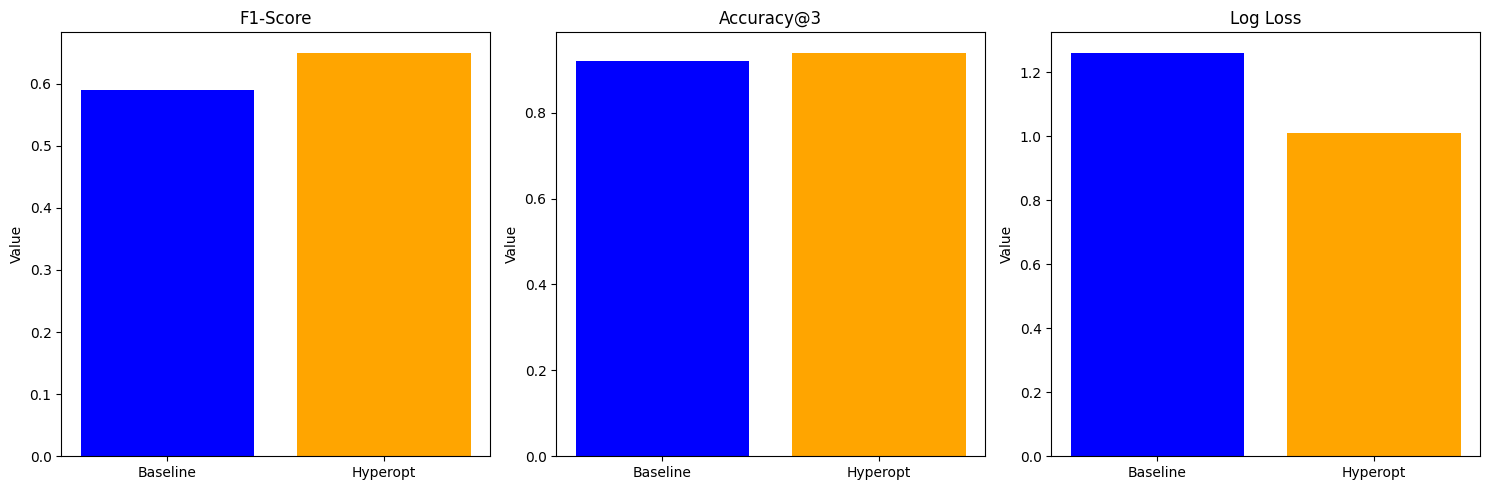

In [29]:
# Create a list of baseline and optimized results for each metric
baseline_f1 = baseline_results['f1']
f1_scores = [baseline_f1, optimized_f1]
baseline_acc_3 = baseline_results['acc3']
acc_3_scores = [baseline_acc_3, optimized_acc_3]
baseline_loss = baseline_results['log_loss']
log_loss_scores = [baseline_loss, optimized_loss]

# Create a bar plot for each metric
metrics = ['F1-Score', 'Accuracy@3', 'Log Loss']
scores = [f1_scores, acc_3_scores, log_loss_scores]
labels = ['Baseline', 'Hyperopt']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (metric, score) in enumerate(zip(metrics, scores)):
    axes[i].bar(labels, score, color=['blue', 'orange'])
    axes[i].set_title(metric)
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()